Kernel size: 8. 

1D Convolutional layer

RNA tetraloop classifier for 44 classes of tetraloops and 1 class without tetraloop annotations. 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn import preprocessing
import tensorflow as tf
import math
from numpy import asarray
from numpy import save
from numpy import load
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv1D, Conv2D, MaxPooling2D, Dropout, Flatten, Input, MaxPooling1D
from sklearn.preprocessing import StandardScaler
import os
import tempfile
from tensorflow import keras
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.utils import to_categorical
import matplotlib as mpl
import sklearn

In [ ]:
EPOCHS = 20
BATCH_SIZE = 8
mpl.rcParams['figure.figsize'] = (15, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Load dataset.
# Please change this to the correspond directory. 
# Datasets are saved in the shared Google drive: deep-learning-RNA-structure-prediction/Chih-Fan/TetraloopsDatasets
# In case you are not the owner of this folder, you have to make a copy (either the entire folder or files) to your own drive. 
dict_train = np.load('./drive/MyDrive/deep-learning-RNA-structure-prediction/Chih-Fan/TetraloopsDatasets/noAnno_train_array.npz')  
x_train = np.stack(dict_train['arr_0'], axis=0)
y_flt_train = np.load('./drive/MyDrive/deep-learning-RNA-structure-prediction/Chih-Fan/TetraloopsDatasets/noAnno_train_labels.npy')
y_train = y_flt_train.astype(int)
y_train_oh = to_categorical(y_train, num_classes=45)  # Make labels into one-hot encode. 

dict_test = np.load('./drive/MyDrive/deep-learning-RNA-structure-prediction/Chih-Fan/TetraloopsDatasets/noAnno_test_array.npz')
x_test = np.stack(dict_test['arr_0'], axis=0)
y_flt_test = np.load('./drive/MyDrive/deep-learning-RNA-structure-prediction/Chih-Fan/TetraloopsDatasets/noAnno_test_labels.npy')
y_test = y_flt_test.astype(int)
y_test_oh = to_categorical(y_test, num_classes=45)  # Make labels into one-hot encode. 

print('Training features shape:', x_train.shape)
print('Test features shape:', x_test.shape)
print('Training labels shape:', y_train_oh.shape)
print('Test labels shape:', y_test_oh.shape)

Training features shape: (1513639, 8, 4)
Test features shape: (756845, 8, 4)
Training labels shape: (1513639, 45)
Test labels shape: (756845, 45)


In [ ]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'),
      keras.metrics.CategoricalAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

In [ ]:
print('Training labels shape:', y_train_oh.shape)
print('Test labels shape:', y_test_oh.shape)

print('Training features shape:', x_train.shape)
print('Test features shape:', x_test.shape)


Training labels shape: (1513639, 45)
Test labels shape: (756845, 45)
Training features shape: (1513639, 8, 4)
Test features shape: (756845, 8, 4)


In [ ]:
def make_model(metrics=METRICS, output_bias=None):
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)
  
  model = Sequential([
    # The input shape is 8x4
    # This is the first convolution
    Conv1D(64, 3, strides=1, activation='relu',padding='same', #4(possible base)^3(kernal size)=64
                 input_shape=(8, 4),
                 kernel_initializer='he_normal',  
                 bias_initializer='zeros'),
    MaxPooling1D(pool_size=2, strides=2),
    Dropout(0.2),
    Conv1D(32, 3, strides=1, activation='relu',padding='same', 
                 kernel_initializer='he_normal',
                 bias_initializer='zeros'),
    MaxPooling1D(pool_size=2, strides=2),    
    Dropout(0.2),
    Flatten(),
    #  neuron hidden layer
    Dense(128, activation='relu', bias_initializer=output_bias, kernel_initializer='he_normal'),  #8/2(maxpooling)=4, 32*4 = 128
    Dropout(0.2),
    # Only 1 output neuron. It will contain a value from 0-1 where 0 for class ('not GNRA') and 1 for the other ('GNRA')
    Dense(45, activation='softmax', bias_initializer=output_bias, kernel_initializer='glorot_uniform')  #Softmax for multiclass classification problem. Glorot for softmax.
    ])
     
  model.compile(
    # Note that the learning rate is 1e-4 which yields higher accuracy. 
    optimizer=keras.optimizers.Adam(learning_rate=1e-4), #optimizer=RMSprop(lr=0.001),
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=METRICS)  # Accuracy for classification problems. 
  
  return model


In [ ]:
# Plot loss and accuracy.
def plot_metrics(history):
  metrics = ['loss', 'accuracy']
  plt.rcParams['font.size'] = '16'
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(1,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_' + metric],
             color=colors[0], linestyle="--", label='Test')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'accuracy':
      plt.ylim([0,1])
    else:
      plt.ylim([0,1])

    plt.legend();

In [ ]:
# Plot ROC curve.
def plot_roc(name, labels, predictions, **kwargs):
  fpr, tpr, _ = sklearn.metrics.roc_curve(labels, predictions)  # fpr=false positive rate = fp/(fp+tn), tpr=true positive rate = tp/(tp+fn)

  plt.plot(100*fpr, 100*tpr, label=name, linewidth=2, **kwargs)
  plt.xlabel('False positives rate = fp/(fp+tn)')
  plt.ylabel('True positives rate = tp/(tp+fn)')
  plt.xlim([-5,100])
  plt.ylim([0,100])
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')

In [ ]:
# Plot precision-recall curve (for binary problem)
def plot_prc(name, labels, predictions, **kwargs):
    precision, recall, _ = sklearn.metrics.precision_recall_curve(labels, predictions)

    plt.plot(precision, recall, label=name, linewidth=2, **kwargs)
    plt.xlabel('Recall  - TP / (TP + FP)')
    plt.ylabel('Precision - TP / (TP + FN)')
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

In [ ]:
# retrain with class weights
# The sum of the weights of all examples stays the same.
y_integers = np.argmax(y_train_oh, axis=1)
class_weights = np.round(class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_integers), y=y_integers), 2)
d_class_weights = dict(enumerate(class_weights))
  
print(d_class_weights)

{0: 0.02, 1: 5.08, 2: 51.75, 3: 94.48, 4: 114.02, 5: 107.81, 6: 142.53, 7: 143.75, 8: 152.2, 9: 180.84, 10: 177.97, 11: 192.21, 12: 195.56, 13: 201.42, 14: 218.42, 15: 221.29, 16: 240.26, 17: 243.74, 18: 254.82, 19: 254.82, 20: 336.36, 21: 415.26, 22: 410.2, 23: 6727.28, 24: 622.9, 25: 747.48, 26: 840.91, 27: 840.91, 28: 862.47, 29: 885.17, 30: 6727.28, 31: 885.17, 32: 1051.14, 33: 1121.21, 34: 1201.3, 35: 33636.42, 36: 33636.42, 37: 33636.42, 38: 33636.42, 39: 16818.21, 40: 1601.73, 41: 1770.34, 42: 1868.69, 43: 2102.28, 44: 33636.42}


In [ ]:
# Train the CNN model on the training set and evaluate by test set.
weighted_model = make_model()
#weighted_model.load_weights(initial_weights)

# model.fit trains the model for a fixed number of epochs (iterations on a dataset).
weighted_history = weighted_model.fit(
    x_train,
    y_train_oh, 
    validation_data = (x_test, y_test_oh),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,

    # The class weights go here
    class_weight=d_class_weights)

Epoch 1/20
189205/189205 [==============================] - 704s 4ms/step - loss: 3.8069 - tp: 84586.0000 - fp: 137999.0000 - tn: 66518080.0000 - fn: 1429053.0000 - accuracy: 0.2608 - precision: 0.3800 - recall: 0.0559 - auc: 0.9177 - prc: 0.2083 - val_loss: 1.7590 - val_tp: 163123.0000 - val_fp: 139758.0000 - val_tn: 33166580.0000 - val_fn: 593722.0000 - val_accuracy: 0.4332 - val_precision: 0.5386 - val_recall: 0.2155 - val_auc: 0.9587 - val_prc: 0.3836
Epoch 2/20
189205/189205 [==============================] - 665s 4ms/step - loss: 4.3715 - tp: 428715.0000 - fp: 355441.0000 - tn: 66275540.0000 - fn: 1084924.0000 - accuracy: 0.4299 - precision: 0.5467 - recall: 0.2832 - auc: 0.9569 - prc: 0.4272 - val_loss: 1.8143 - val_tp: 190770.0000 - val_fp: 139478.0000 - val_tn: 33166936.0000 - val_fn: 566075.0000 - val_accuracy: 0.3971 - val_precision: 0.5777 - val_recall: 0.2521 - val_auc: 0.9568 - val_prc: 0.3986
Epoch 3/20
189205/189205 [==============================] - 659s 3ms/step - los

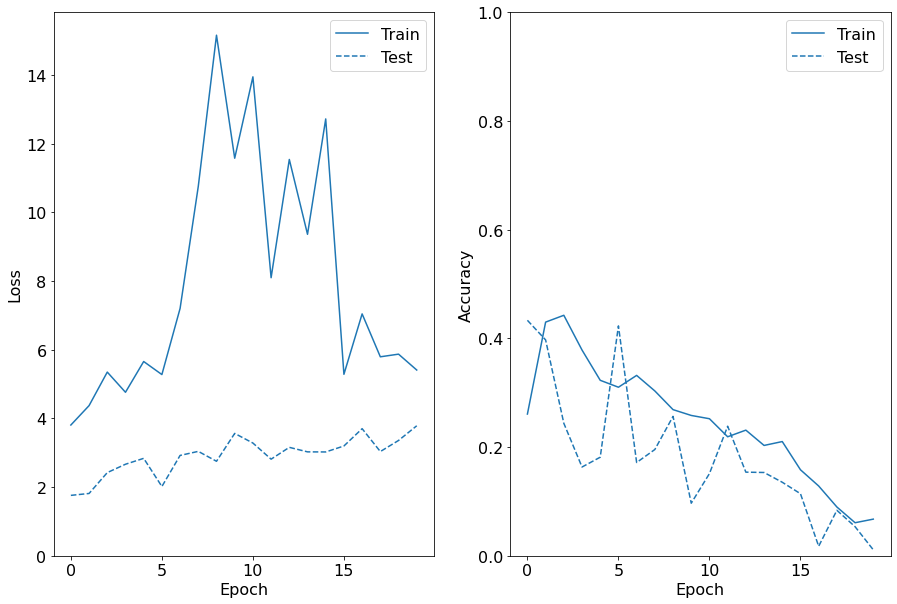

In [ ]:
plot_metrics(weighted_history)

In [ ]:
# Model.predict gives the predicted output. 
train_predictions_weighted = weighted_model.predict(x_train, batch_size=BATCH_SIZE)
test_predictions_weighted = weighted_model.predict(x_test, batch_size=BATCH_SIZE)

94606/94606 [==============================] - 101s 1ms/step


In [ ]:
# Results of test data set. 
# model.evaluate returns the loss value & metrics values for the model in test mode (the model is already trained).
weighted_results = weighted_model.evaluate(x_test, y_test_oh,
                                           batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(weighted_model.metrics_names, weighted_results):
  print(name, ': ', value)
print()

plot_cm(y_test_oh, test_predictions_weighted)

loss :  3.784733772277832
tp :  4565.0
fp :  10034.0
tn :  33295216.0
fn :  752280.0
accuracy :  0.010998289100825787
precision :  0.31269264221191406
recall :  0.006031617987900972
auc :  0.5896690487861633
prc :  0.031488172709941864



NameError: ignored

In [ ]:
plot_roc("Train Weighted", y_train, train_predictions_weighted, color=colors[1])
plot_roc("Test Weighted", y_test, test_predictions_weighted, color=colors[1], linestyle='--')


plt.legend(loc='lower right');

In [ ]:
plot_prc("Train Weighted", y_train, train_predictions_weighted, color=colors[1])
plot_prc("Test Weighted", y_test, test_predictions_weighted, color=colors[1], linestyle='--')

plt.legend(loc='lower right');